<a href="https://colab.research.google.com/github/krislars/DustTools/blob/main/Example_Green19_3D_Dust_Maps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook demonstrates how to get the Green et al. (2019) extinction values and maps around a specific source without hardcoding in the source coordinates.

Kristen Larson (krislars@gmail.com), Oct 2023

## References

Green et al. (2019, etc)

*A 3D Dust Map Based on Gaia, Pan-STARRS 1, and 2MASS*

Paper: https://ui.adsabs.harvard.edu/abs/2019ApJ...887...93G/abstract

Code: https://dustmaps.readthedocs.io/




## Installs and Imports

In [ ]:
!pip install dustmaps

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 458.9/458.9 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 32.6 MB/s eta 0:00:00


In [78]:
from astropy.coordinates import SkyCoord
from astropy import units as u
from dustmaps.sfd import SFDWebQuery
from dustmaps.bayestar import BayestarWebQuery
from ipywidgets import interactive
from matplotlib import pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

## Example: T Tau

### Select source

Astropy coordinates package will get the source coordinates from a name lookup.

In [ ]:
name = 'T Tau'
c = SkyCoord.from_name(name)
c

<SkyCoord (ICRS): (ra, dec) in deg
    (65.49763328, 19.53512011)>

### Get SFD98 values (historical)

The SFD reddening map was the gold standard for well over a decade.  You can get these

In [ ]:
sfd = SFDWebQuery()
print('SFD98 E(B-V) = ',np.round(sfd(c),2))

SFD98 E(B-V) =  0.6


### Get Green+19 values

From their paper: "Bayestar19 reports reddening in an arbitrary unit that can be converted to extinction in different bands using the coefficients given in Table 1 of Green, Schlafly, Finkbeiner et al. (2019)."

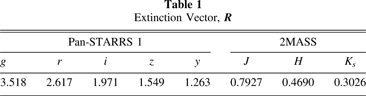



In [ ]:
Rg = 3.518
RJ = 0.7927

The distance in the cell below should be near, or at least beyond, the source in question.  We will show, in a subsequent cell, how an incorrect distance (such as this one!) can cause the extinction to be overestimated or underestimated.  Green+19 maps are a probabilistic sampling, so the mode specifies what to return from the sampling.

In [ ]:
# If NaN, then not in the Green+ footprint
coords = SkyCoord(c.ra, c.dec, distance=1*u.kpc, frame='icrs')
green = BayestarWebQuery(version='bayestar2019')
print('Green19 A(g) = ',np.round(Rg*green(coords, mode='median'),2))
print('Green19 A(J) = ',np.round(RJ*green(coords, mode='median'),2))

Green19 A(g) =  3.59
Green19 A(J) =  0.81


### Investigate Line of Sight

We can get extinction at a range of distances to investigate the foreground cloud structure and ultimate distance limit of the Green+19 maps.

In [ ]:
dist = np.arange(50,1000,10)*u.pc
coords = SkyCoord(c.ra, c.dec, distance=dist, frame='icrs')
green = BayestarWebQuery(version='bayestar2019')
E19 = green(coords, mode='median')

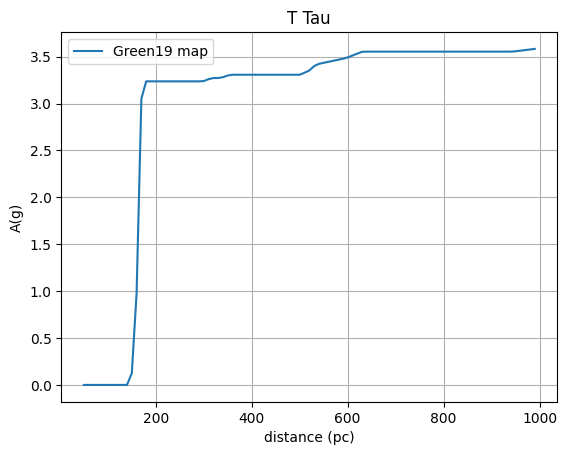

In [ ]:
plt.plot(dist,Rg*E19,label='Green19 map')
plt.xlabel('distance (pc)')
plt.ylabel('A(g)')
plt.title(name)
plt.grid(True)
plt.legend()
plt.show()

Cloud location leads to a step increase in extinction at that distance.  Notice that in this case, it looks as if there is a cloud at 150 pc and 500 pc.

T Tau is very nearby, roughly 145 pc, so our initial calculation is an overestimate.  Let's re-run with a better distance value.

In [ ]:
coords = SkyCoord(c.ra, c.dec, distance=145*u.pc, frame='icrs')
green = BayestarWebQuery(version='bayestar2019')
print('Green19 A(g) = ',np.round(Rg*green(coords, mode='median'),2))

Green19 A(g) =  0.02


That's more like it.  There is very little interstellar extinction in the foreground of T Tau.

Notice, too, that the Green+19 map saturates at long distance because of the lack of stars in the dataset at those distances.

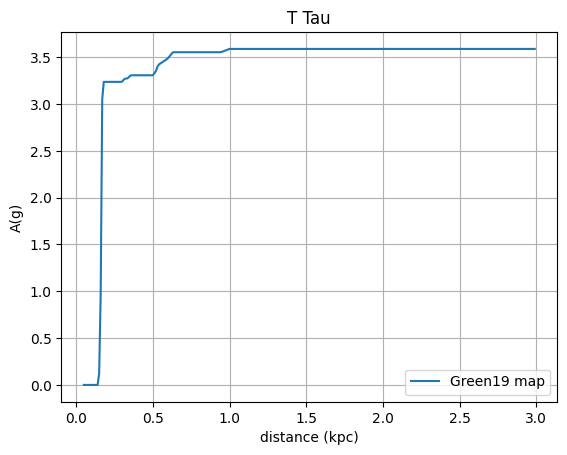

In [ ]:
dist = np.arange(0.050,3,0.010)*u.kpc
coords = SkyCoord(c.ra, c.dec, distance=dist, frame='icrs')
green = BayestarWebQuery(version='bayestar2019')
E19 = green(coords, mode='median')
plt.plot(dist,Rg*E19,label='Green19 map')
plt.xlabel('distance (kpc)')
plt.ylabel('A(g)')
plt.title(name)
plt.grid(True)
plt.legend()
plt.show()

### Extinction maps

Choose a distance and extent for the extinction map.

In [ ]:
range = 0.5 # in deg
dist = 145 * u.pc

In [ ]:
ra_arr = np.arange(c.ra.deg-range,c.ra.deg+range,0.01) * u.deg
dec_arr = np.arange(c.dec.deg-range,c.dec.deg+range,0.01) * u.deg
ragrid,decgrid = np.meshgrid(ra_arr,dec_arr)

In [ ]:
coords = SkyCoord(ragrid, decgrid, distance=dist)
E19_map = green(coords, mode='median')

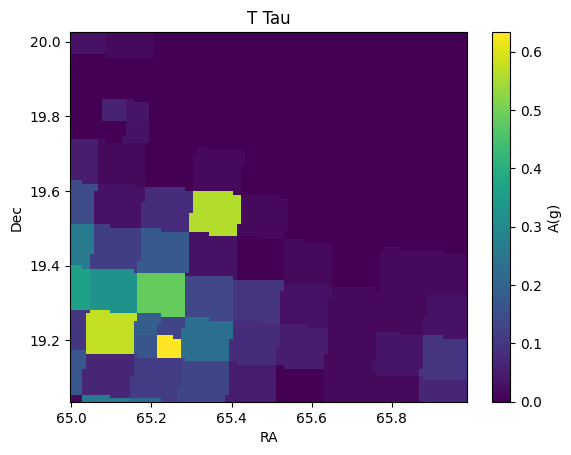

In [83]:
plt.imshow(E19_map*Rg, origin='lower', vmin=0, aspect='auto',
           extent = [ra_arr.value.min(), ra_arr.value.max(),
                     dec_arr.value.min(), dec_arr.value.max()])
plt.colorbar(label='A(g)')
plt.xlabel('RA')
plt.ylabel('Dec')
plt.title(name)
plt.show()

Here is the same plot over a range of distances.

In [84]:
def f(d):
    coords = SkyCoord(ragrid, decgrid, distance=d*u.pc)
    E19_map = green(coords, mode='median')
    plt.imshow(E19_map*Rg, origin='lower', vmin=0, vmax=3.5, aspect='auto',
           extent = [ra_arr.value.min(), ra_arr.value.max(),
                     dec_arr.value.min(), dec_arr.value.max()])
    plt.colorbar(label='A(g)')
    plt.xlabel('RA')
    plt.ylabel('Dec')
    plt.title(name)
    plt.show()

interactive_plot = interactive(f, d=(50,1000,10))
interactive_plot

interactive(children=(IntSlider(value=520, description='d', max=1000, min=50, step=10), Output()), _dom_classe…